In [2]:
import sys
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Bernoulli, Normal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import gymnasium as gym

from PIL import Image
from time import sleep
from pathlib import Path


# # code for the only two actions in Pong
# # 2 -> UP, 3 -> DOWN
# ACTIONS = [2, 3]

In [3]:
cd /content/drive/MyDrive/RLProject2023

/content/drive/MyDrive/RLProject2023


In [4]:
pip freeze > requirements.txt

## Helper Functions

In [5]:
def discount_rewards(reward):
    # Compute the gamma-discounted rewards over an episode
    gamma = 0.99    # discount rate
    running_add = 0
    discounted_r = torch.zeros_like(reward)

    for i in reversed(range(0, len(reward))):
        if reward[i] != 0: # reset the sum if demand is fully met and cabs don't need to be repositioned
            running_add = 0
        running_add = running_add * gamma + reward[i]
        discounted_r[i] = running_add

    discounted_r -= torch.mean(discounted_r) # normalizing the result
    discounted_r /= torch.std(discounted_r) # divide by standard deviation
    return discounted_r


def log(filename, string):
    with open(filename, 'a+') as logger:
        logger.write(string)

def update_demand(pt, at):
    '''
    Parameters:
    pt - Number of passengers who want to go from zone i to j - NxN matrix in timepoint t 
    new_pt - New Demand generated for timepoint t+1 - NxN matrix 
    at - Agents action, cabs displaced to satisfy demand from zone i to j - NxN matrix 
    
    Returns: 
    unsatisfied_pt - Unsatisfied demand to be carried forward  
    '''
    unsatisfied_pt = pt - at 
    unsatisfied_pt[unsatisfied_pt<0] = 0 
    
    return unsatisfied_pt

def update_supply(pt,vt, frozen, times, at):
    '''
    Parameters: 
    vt - Number of empty vehicles in each zone at time t - Nx1 vector 
    frozen - Nxt matrix with rows as destination and columns as remaining timesteps of journey 
        fjk: the number of cabs on a journey with destination j and timepoint k remaining 
    times - NxN matrix of time a trip from i to j will take 
    at - Agents action, cabs displaced to satisfy demand from zone i to j - NxN matrix
    
    Returns: 
    vt_next - Number of empty vehicles in each zone at time t+1 
    frozen_next - Updated frozen vehicle matrix 
    '''
    num_zones = frozen.shape[0]
    extra_vt = at - pt 
    extra_vt[extra_vt<0]=0
    extra_vt = np.sum(extra_vt, axis = 1) 

    for i in range(num_zones):
        for j in range(num_zones):
            frozen[j, times[i,j]-1] = at[i,j]
    return extra_vt, frozen


def get_reward(pt, at, wait_cost, move_cost):
    '''
    Parameters:
    pt: current demand matrix of the shape num_zones x num_zones
    at: action taken by the model. Aij defines how many cabs will move from zone i to j
    wait_cost: cost matrix defining the penalty for passengers waiting for a cab from zone i to j
    move_cost: cost matrix defining the penalty for relocating empty cabs zone i to j

    Returns: 
    reward: The total reward that the agent earns for taking the current action
    '''
    yt = np.minimum(at, pt)
    reward = -1 * np.sum((pt-yt)*wait_cost + (at-yt)*move_cost)
    return reward 
    

## Actor Critic Models

In [8]:
class Actor(nn.Module):
    def __init__(self, input_size, action_size):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)
    
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        action_mu = self.output(x)
        return action_mu


class A2CAgent(object):

    def __init__(self, num_zones,input_size, log_filename):    
        self.num_zones = num_zones
        self.actor = Actor(input_size, self.num_zones*self.num_zones) # the output would be a matrix of dimension num_zones*num_zones
        self.optimizerA = optim.SGD(self.actor.parameters(), lr=0.001, weight_decay=0.99)

        self.memory = {
            'rewards': [],
            'log_probs': [],
            'states': []
        }
        self.epoch = 0
        self.log_filename = log_filename
    
    def select_action(self, state, available_cabs):
        '''
        Parameters:
        state: current demand matrix tensor of the shape (num_zones*num_zones,1)
        available_cabs: available cabs in each zone -> shape = (num_zones,1)
        
        Returns:
        The action matrix of the shape (num_zones,num_zones)
        '''
        num_of_zones=self.num_zones

        # sample an action from stochastic policy
        action_mu = self.actor.forward(state)
        
        dist = Normal(action_mu,torch.ones(action_mu.size(dim=0)))
        sampled_val = dist.sample()
        self.memory['log_probs'].append(torch.sum(dist.log_prob(sampled_val)))

        sampled_val = sampled_val.numpy()
        actions= np.zeros((num_of_zones,num_of_zones))
        for i in range(num_of_zones):
          zone = np.abs(sampled_val[i*num_of_zones:(i+1)*num_of_zones])
          zone = zone/np.sum(zone)
          actions[i,:] = zone*available_cabs[i]

        return actions #6x6 matrix with rows as source and columns as destination


    def remember(self, reward):
        '''
        Adds reward to memory queue

        Parameters:
        reward: reward earned by the agent at timestep t+1
        '''
        self.memory['rewards'].append(reward)
    

    def update_network(self):

        '''
        Training the network on the past experiences of the agent
        '''
        len_r = len(self.memory['rewards'])
        assert len_r == len(self.memory['log_probs'])

        # convert to tensors for ease of operation
        self.memory['rewards'] = torch.tensor(self.memory['rewards'], dtype=torch.float32)
        discounted_r = discount_rewards(self.memory['rewards']).unsqueeze(1)
        self.memory['log_probs'] = torch.stack(self.memory['log_probs'])

        policy_losses = (-1 * self.memory['log_probs']) * discounted_r

        # crux of training
        self.optimizerA.zero_grad()
        self.lossA = policy_losses.sum()
        self.lossA.backward()
        self.optimizerA.step()

        # reset memory because this is on-policy
        for k in self.memory.keys():
            self.memory[k] = []
    
 
    def learn(self, master_pt,wait_cost,move_cost, times,num_epochs, roll_size, start,number_cabs):
        '''
        Parameters:
        master_pt: demand corresponding to all timesteps. shape->(num_zones, num_zones, timesteps)
        wait_cost: cost matrix defining the penalty for passengers waiting for a cab from zone i to j
        move_cost: cost matrix defining the penalty for relocating empty cabs zone i to j
        times: time matrix defining trip times between zone i and j
        num_epochs: number of epochs to train for
        roll_size: defining how frequenctly we train our network and log data
        start: starting epoch
        number_cabs: number of cabs in the system
        '''
        print(f"Resuming from {start + 1}, Writing to {self.log_filename}\n")

        assert roll_size == 10

        avg = -float('inf')
        best_avg = -float('inf')
        max_score = -float('inf')
        num_zones = 6
        max_time = 4
        num_cabs = number_cabs
        timestep_per_episode =48

        all_scores = np.zeros((num_epochs, ), dtype=np.int32)
        state_matrix = [] #np.zeros((num_zones, num_zones, num_epochs*timestep_per_episode))
        percentage_insatiated_demand_matrix = np.zeros((num_epochs*timestep_per_episode,))
        percentage_empty_cabs_matrix = np.zeros((num_epochs*timestep_per_episode,))
        timestep = 0
        global_timestep = 0

        for eps_idx in range(start + 1, num_epochs):
            # print("timestep",timestep)
            self.epoch = eps_idx
            
            # beginning of an episode
            #48 timesteps in 1 episode (day)
            state=np.zeros((num_zones,num_zones))
            available_cabs = np.array([num_cabs//num_zones]*num_zones)
            frozen = np.zeros((num_zones,max_time))
            score = 0
            done=False
            
            # print("done-",done)
            while not done:
                #get new demand
                state += master_pt[:,:, timestep]
                initial_demand = np.sum(state)

                state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
                
                #unfreeze cabs
                available_cabs = available_cabs + frozen[:,0]
                frozen[:,0]=0
                frozen = np.roll(frozen, -1, axis = 1)
                
                initial_supply = np.sum(available_cabs)

                #take action
                action = self.select_action(state_tensor, available_cabs)
                
                #computing reward
                reward = get_reward(state, action,wait_cost,move_cost)

                #storing in memory
                self.remember(reward)

                #updating supply
                available_cabs, frozen = update_supply(state, available_cabs, frozen, times, action)
                
                # updating demand
                state = update_demand(state, action)

                state_matrix.append(state)
                
                insatiated_demand = initial_demand - np.sum(state)
                percentage_insatiated_demand = insatiated_demand / initial_demand
                percentage_insatiated_demand_matrix[global_timestep] = percentage_insatiated_demand 
                
                if initial_supply==0:
                  percentage_empty_cabs_matrix[global_timestep] = 0 
                else: 
                  empty_cabs = initial_supply - np.sum(available_cabs)
                  percentage_empty_cabs = empty_cabs/initial_supply
                  percentage_empty_cabs_matrix[global_timestep] = percentage_empty_cabs 

                score += reward
                timestep = (timestep+1)%master_pt.shape[2]
                global_timestep+=1
                # print("INSIDE EPISODE LOOP ",timestep)
                done = True if timestep%timestep_per_episode==0 else False #48 timesteps in one episode

            # bookkeeping of stats
            all_scores[eps_idx] = score
            if score > max_score:
                max_score = score


            
            if ((eps_idx + 1) % roll_size) == 0:
                avg = np.mean(all_scores[(eps_idx + 1) - roll_size:eps_idx])
                if avg > best_avg:
                    best_avg = avg
                    self.save(eps_idx, "checkpoint_bestavg")

                # print(f"\n [{eps_idx}]: {score}, Avg: {avg:.2f}, Max: {max_score}, Best_avg: {best_avg:.2f}")
                stat_string = f" [{eps_idx}]: {score}, Avg: {avg:.2f}, Max: {max_score}, Best_avg: {best_avg:.2f}\n"
                log(self.log_filename, stat_string)
                self.save(eps_idx, "checkpoint_latest")

                sys.stdout.write(f"\r [{eps_idx}]: {score}, Avg: {avg:.2f}, Max: {max_score}, Best_avg: {best_avg:.2f}")
                sys.stdout.flush()

                np.save('checkpoints/all_scores.npy', all_scores, allow_pickle=False)
                np.save('checkpoints/percentage_insatiated_demand_matrix.npy', percentage_insatiated_demand_matrix, allow_pickle=False)
                np.save('checkpoints/percentage_empty_cabs_matrix.npy', percentage_empty_cabs_matrix, allow_pickle=False)
            # train every 10 episodes
            if ((eps_idx + 1) % 10) == 0:
                self.update_network()
            
            # graph the scores every 100 eps
            if ((eps_idx + 1) % 100) == 0:
                pass
        
        avg = np.mean(all_scores)
        max_score = np.max(all_scores)
        print(f"\n [{eps_idx}]: {score}, Avg: {avg:.2f}, Max: {max_score}, Best_avg: {best_avg:.2f}")
        
        return all_scores, percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix, state_matrix


    def save(self, epoch, path):
        save_dir = 'checkpoints/'
        path = save_dir + path + ".pt"

        Path(save_dir).mkdir(exist_ok=True)

        try:
            lossA = self.lossA
            # lossC = self.lossC
        except AttributeError:
            lossA = None
            # lossC = None

        torch.save(
            {
                'epoch': epoch,
                'actor_state_dict': self.actor.state_dict(),
                # 'critic_state_dict': self.critic.state_dict(),
                'optimizerA_state_dict': self.optimizerA.state_dict(),
                # 'optimizerC_state_dict': self.optimizerC.state_dict(),
                'lossA': lossA,
                # 'lossC': lossC,
            },
            path
        )

    def load(self, path):
        save_dir = 'checkpoints/'
        path = save_dir + path + ".pt"

        checkpoint = torch.load(path)

        epoch = checkpoint['epoch']
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        # self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.optimizerA.load_state_dict(checkpoint['optimizerA_state_dict'])
        # self.optimizerC.load_state_dict(checkpoint['optimizerC_state_dict'])

        return epoch


    def perform(self, master_pt_test, number_cabs):

      avg = -float('inf')
      best_avg = -float('inf')
      max_score = -float('inf')
      num_zones = 6
      max_time = 4
      num_cabs = number_cabs
      timestep_per_episode =48

      all_scores = np.zeros((master_pt_test.shape[2], ), dtype=np.int32)
      percentage_insatiated_demand_matrix = np.zeros((master_pt_test.shape[2],))
      percentage_empty_cabs_matrix = np.zeros((master_pt_test.shape[2],))

      for i in range(master_pt_test.shape[2]):
        print("timestep:", i)
        #48 timesteps in 1 episode (day)
        if i==0:
          state=np.zeros((num_zones,num_zones))
          available_cabs = np.array([num_cabs//num_zones]*num_zones)
          frozen = np.zeros((num_zones,max_time))
          score = 0

        state += master_pt[:,:, i]

        initial_demand = np.sum(state)

        state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
        
        #unfreeze cabs
        available_cabs = available_cabs + frozen[:,0]
        frozen[:,0]=0
        frozen = np.roll(frozen, -1, axis = 1)
        
        initial_supply = np.sum(available_cabs)

        #take action
        action = self.select_action(state_tensor, available_cabs)
        
        #computing reward
        reward = get_reward(state, action,wait_cost,move_cost)

        #storing in memory
        # self.remember(reward)

        #updating supply
        available_cabs, frozen = update_supply(state, available_cabs, frozen, times, action)
        
        # updating demand
        state = update_demand(state, action)
        
        insatiated_demand = initial_demand - np.sum(state)
        percentage_insatiated_demand = insatiated_demand / initial_demand
        percentage_insatiated_demand_matrix[i] = percentage_insatiated_demand 
        
        if initial_supply==0:
          percentage_empty_cabs_matrix[i] = 0 
        else: 
          empty_cabs = initial_supply - np.sum(available_cabs)
          percentage_empty_cabs = empty_cabs/initial_supply
          percentage_empty_cabs_matrix[i] = percentage_empty_cabs 


        # bookkeeping of stats
        all_scores[i] = reward
      return all_scores, percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix

## Driver

In [9]:
def plot_scores(scores, timedelta):
  index=0
  s=[]
  while index<len(scores):
    temp =np.sum(scores[index:index+timedelta])/timedelta
    index+=timedelta
    s.append(temp)
  plt.plot(s)
  plt.ylabel('Average Reward')
  plt.xlabel('Timestep')
  plt.savefig("scores_22.png")

In [10]:
def plot_demand_supply(percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix, timedelta):
  index=0
  s=[]
  s1=[]
  while index<len(percentage_insatiated_demand_matrix):
    temp =np.sum(percentage_insatiated_demand_matrix[index:index+timedelta])/timedelta
    temp1 = np.sum(percentage_empty_cabs_matrix[index:index+timedelta])/timedelta
    index+=timedelta
    s.append(temp)
    s1.append(temp1)
  plt.plot(s1, label='Available Cabs')
  plt.plot(s, label='Insatiated Demand', alpha=0.5)
  plt.legend()
  plt.xlabel('Timestep')
  plt.ylabel('Fractions')
  plt.savefig("Demandvssupply.png")

In [11]:
def driver(master_pt_path, wait_cost, move_cost, times,  num_of_epochs, number_of_cabs):
  num_of_zones=6
  num_of_epochs=  num_of_epochs

  master_pt = np.load(master_pt_path)

  if Path('logs.txt').exists():
      print("Logs already exist, appending to them.")

  agent = A2CAgent(num_of_zones, num_of_zones*num_of_zones, 'logs.txt')

  epoch_resume = -1
  return agent.learn(master_pt,wait_cost,move_cost,times, num_of_epochs, 10, epoch_resume, number_of_cabs)

## Visualizing Results

In [ ]:
#Training on entire 2022 dataset
number_of_cabs=2400
num_of_epochs=20000
master_pt_path = './RL-data/master_pt_2022.npy'
wait_cost = np.load("./RL-data/wait_costs_22.npy")
move_cost = np.load("./RL-data/move_costs_22.npy")
times= np.load("./RL-data/times_small.npy")
all_scores, percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix = driver(master_pt_path, wait_cost, move_cost, times, num_of_epochs, number_of_cabs)

In [ ]:
plot_scores(all_scores,200)

In [ ]:
plot_scores(all_scores,100)

In [ ]:
#Training on Jan2023
number_of_cabs=2000
num_of_epochs=10000
master_pt_path = './RL-data/master_pt_small.npy'
wait_cost = np.load("./RL-data/wait_costs_small.npy")
move_cost = np.load("./RL-data/move_costs_small.npy")
times= np.load("./RL-data/times_small.npy")
all_scores, percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix = driver(master_pt_path, wait_cost, move_cost, times, num_of_epochs, number_of_cabs)

In [ ]:
plot_scores(all_scores,100)

In [ ]:
plot_demand_supply(percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix,4800)

# Further Evaluations

In [12]:
master_pt_path = './RL-data/master_pt_2022.npy'
master_pt = np.load(master_pt_path)
wait_cost = np.load("./RL-data/wait_costs_22.npy")
move_cost = np.load("./RL-data/move_costs_22.npy")
times= np.load("./RL-data/times_small.npy")

In [13]:
master_pt_jan_22 = master_pt[:,:,:1488]
master_pt_dec_22 = master_pt[:,:,-1488:]

In [14]:
master_pt_jan_22.shape, master_pt_dec_22.shape

((6, 6, 1488), (6, 6, 1488))

In [15]:
num_of_zones = 6
num_of_epochs =  10000
number_of_cabs = 2000
master_pt = master_pt_jan_22

agent = A2CAgent(num_of_zones, num_of_zones*num_of_zones, 'logs.txt')

epoch_resume = -1
all_scores, percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix, state_matrix = agent.learn(master_pt,wait_cost,move_cost,times, num_of_epochs, 10, epoch_resume, number_of_cabs)

Resuming from 0, Writing to logs.txt

 [9999]: -2208719.377282629, Avg: -674916.33, Max: -107501.76380987949, Best_avg: -296889.11
 [9999]: -2208719.377282629, Avg: -1581290.74, Max: -107501, Best_avg: -296889.11


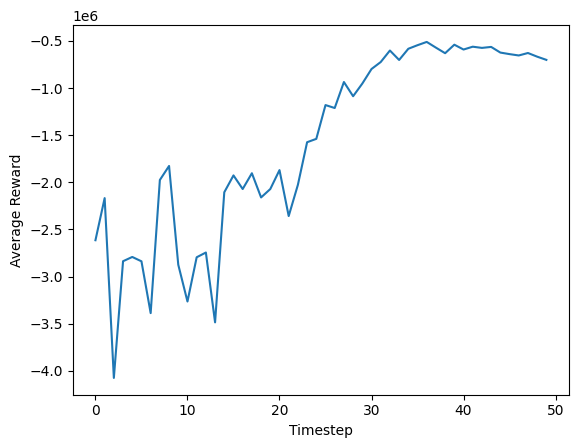

In [16]:
plot_scores(all_scores,200)

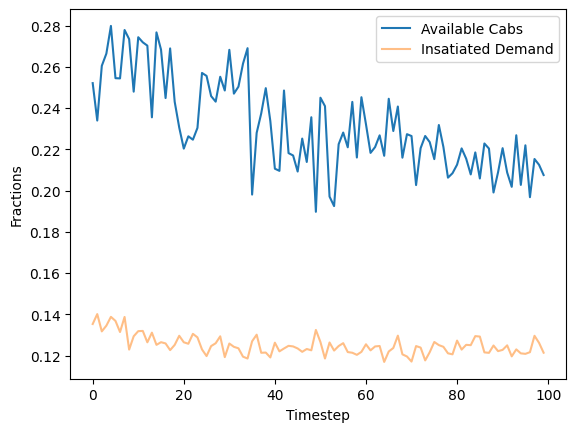

In [17]:
plot_demand_supply(percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix,4800)

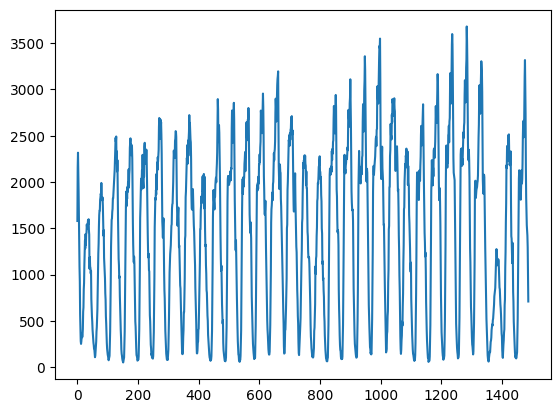

In [18]:
demand = master_pt_jan_22.sum(axis=(0,1))
plt.plot(demand)

In [19]:
len(state_matrix)

480000

In [ ]:
# on test set
number_cabs=2000
master_pt_path = './RL-data/master_pt_small.npy'
master_pt_jan_23 = np.load(master_pt_path)
all_scores, percentage_insatiated_demand_matrix, percentage_empty_cabs_matrix = agent.perform( master_pt_jan_23, number_cabs)

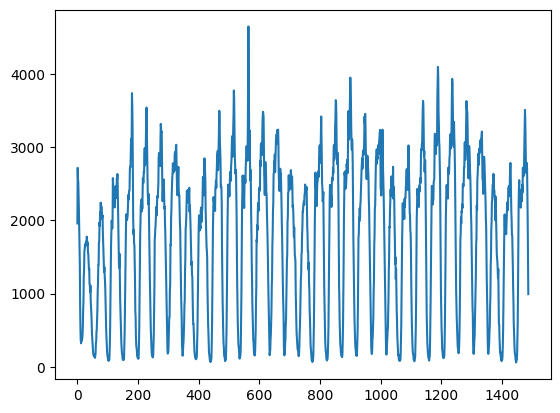

In [30]:
plt.plot(master_pt_jan_23.sum(axis=(0,1)))
# plt.plot(master_pt_jan_23)

In [92]:
master_pt_jan_23.shape

(6, 6, 1488)